### Import Libraries

In [ ]:
pip install imbalanced-learn transformers torch scikit-learn

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

### Read the test and train dataset from the checkpoint

In [34]:
train_df = pd.read_csv("../data/train_dataset_w56types.csv")

In [35]:
train_df.shape

(7222, 12)

## Data Preprocessing

In [36]:
# Get unique count of values in each column
unique_counts = train_df.apply(lambda x: x.nunique())
print("\nUnique Value Counts:")
print(unique_counts)


Unique Value Counts:
project_name                             7160
methodology_or_protocol                   339
fully_harmonized_methodology_protocol     275
version_string                             13
region                                     13
voluntary_registry                          4
project_type_from_the_registry            100
project_developer                        2561
arborwaproject                              4
scope                                       8
type                                       56
rule_based_type_mapping_first              65
dtype: int64


### SMOTE to handle Data Imbalance of minority classes

## Identify the outliers from projectTypes

In [37]:

type_df = train_df["type"]
type_counts = type_df.value_counts().reset_index()
type_counts.columns = ["type", 'count']

type_counts


,type,count
0,Cookstoves,1149
1,Wind,810
2,Improved Forest Management,608
3,Hydropower,422
4,Afforestation/Reforestation,382
5,Manure Methane Digester,358
6,Clean Water,330
7,Landfill Methane,306
8,Solar - Centralized,254
9,Rice Emission Reductions,235


In [10]:
# Based on the Zscore, the major classes will be undersampled and minority classes will be oversample

In [38]:
X_train_df = train_df.drop(columns=['type', 'scope', 'rule_based_type_mapping_first', 'methodology_or_protocol'])
Y_train_df = train_df['type']

In [39]:
print(X_train_df.shape)

(7222, 8)


In [40]:
## Splitting the train to train and validation sets
X_train, X_val, Y_train, Y_val  = train_test_split(X_train_df,Y_train_df, test_size=0.1, stratify =Y_train_df,  random_state=42)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape )

(6499, 8) (723, 8) (6499,) (723,)


## Encoding the categorical and text features


In [41]:
# Define categorical and text features
categorical_features = ['region', 'voluntary_registry', 'arborwaproject']
text_features = ['project_name','fully_harmonized_methodology_protocol',"version_string",'project_type_from_the_registry', 'project_developer']


In [42]:
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocessor for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Preprocessor for text features
text_transformers = [(f'text_{i}', TfidfVectorizer(), col) for i, col in enumerate(text_features)]

# Combine all preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ] + text_transformers,
    remainder='passthrough'
)

# Define SMOTE and RandomUnderSampler
over_sampling = SMOTE(random_state=42,k_neighbors=4 )

# Pipeline for preprocessing and resampling
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversampling', over_sampling)
])

# Apply preprocessing, SMOTE, and undersampling
X_resampled_combined, y_resampled = pipeline.fit_resample(X_train, Y_train)


In [43]:
print(X_resampled_combined.shape, y_resampled.shape)
print(X_resampled_combined.dtype)

(57904, 11676) (57904,)
float64


In [44]:
# Check the class distribution after resampling
resampledCounter = Counter(y_resampled)
originalCounter = Counter(Y_train_df)

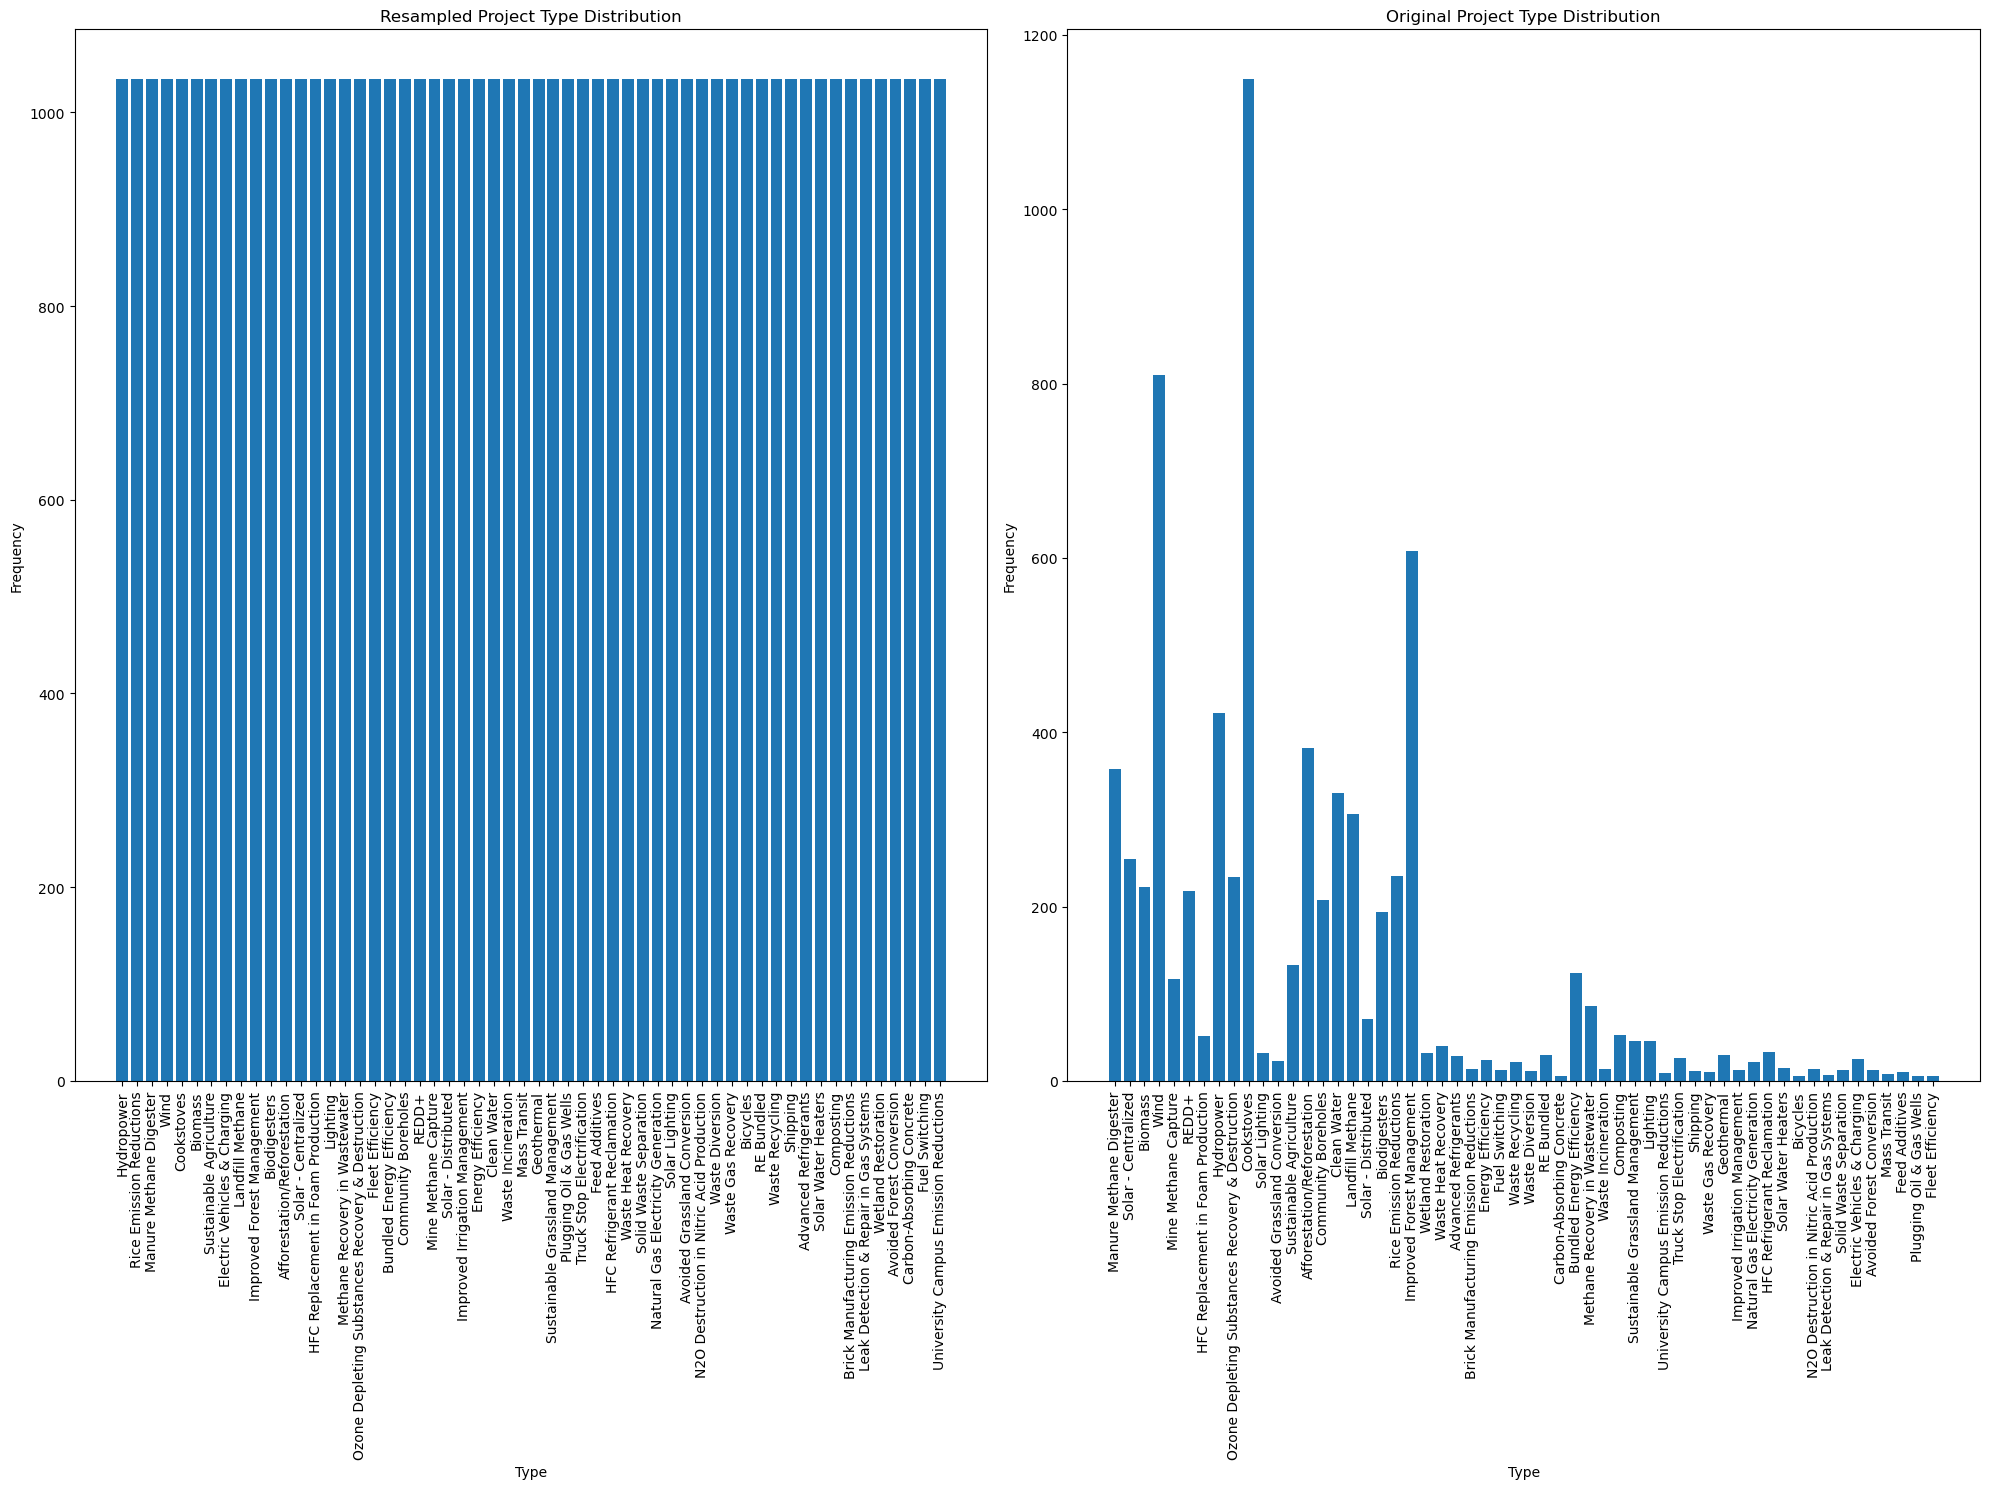

In [45]:
# Plotting histograms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))

# Resampled class distribution histogram
axes[0].bar(resampledCounter.keys(), resampledCounter.values())
axes[0].set_title('Resampled Project Type Distribution')
axes[0].set_xlabel('Type')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(list(resampledCounter.keys()))
axes[0].set_xticklabels(resampledCounter.keys(), rotation=90)

# Original class distribution histogram
axes[1].bar(originalCounter.keys(), originalCounter.values())
axes[1].set_title('Original Project Type Distribution')
axes[1].set_xlabel('Type')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(list(originalCounter.keys()))
axes[1].set_xticklabels(originalCounter.keys(), rotation=90)

# Display the histograms
plt.tight_layout()
plt.show()


### Logistic Regression

In [46]:
# Define the logistic regression model
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)

# Fit the logistic regression model on the resampled data
logistic_regression.fit(X_resampled_combined, y_resampled)


LogisticRegression(max_iter=1000, random_state=42)

In [47]:
# Make predictions on the val data

X_val_transformed = preprocessor.transform(X_val)
y_pred = logistic_regression.predict(X_val_transformed)

# Evaluate the model and get the classification report
report = classification_report(Y_val, y_pred, output_dict=True)

# Convert the classification report to a DataFrame for a tabular format
report_df = pd.DataFrame(report).transpose()

# Display the classification report table
report_df

/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

,precision,recall,f1-score,support
Advanced Refrigerants,1.000000,1.000000,1.000000,3.000000
Afforestation/Reforestation,1.000000,0.921053,0.958904,38.000000
Avoided Forest Conversion,1.000000,1.000000,1.000000,1.000000
Avoided Grassland Conversion,1.000000,1.000000,1.000000,2.000000
Bicycles,1.000000,1.000000,1.000000,1.000000
Biodigesters,1.000000,0.894737,0.944444,19.000000
Biomass,0.750000,0.954545,0.840000,22.000000
Brick Manufacturing Emission Reductions,1.000000,1.000000,1.000000,1.000000
Bundled Energy Efficiency,0.909091,0.833333,0.869565,12.000000
Carbon-Absorbing Concrete,0.000000,0.000000,0.000000,1.000000


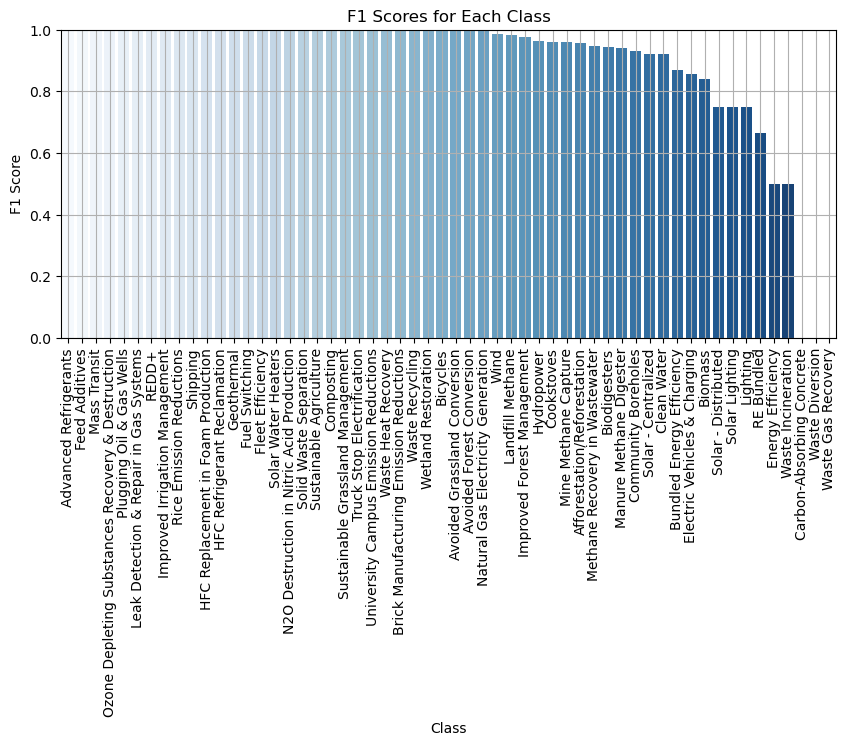

In [48]:
import seaborn as sns
# Extract F1 scores from the classification report
f1_scores = {key: value['f1-score'] for key, value in report.items() if key not in ('accuracy', 'macro avg', 'weighted avg')}

# Convert the F1 scores to a DataFrame for plotting
f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Class', 'F1 Score'])

# Sort the DataFrame by F1 Score in ascending order
f1_df = f1_df.sort_values(by='F1 Score', ascending = False)

# Plot the F1 scores
plt.figure(figsize=(10, 4))
sns.barplot(x='Class', y='F1 Score', data=f1_df, palette='Blues')
plt.title('F1 Scores for Each Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=90)  # Rotate x-ticks by 90 degrees
plt.grid(True)
plt.show()